In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

import numpyro
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS

In [2]:
# Define the SIR model
def sir_ode(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return jnp.array([dSdt, dIdt, dRdt])

# Solve the SIR model using JAX's odeint
def solve_sir(t, beta, gamma, S0, I0, R0):
    y0 = jnp.array([S0, I0, R0])  # Initial conditions
    solution = odeint(sir_ode, y0, t, beta, gamma)  # Pass beta and gamma directly as arguments
    return solution

In [3]:
def numpyro_sir_model(t, S0, I0, R0, new_cases):
    # Priors for kinetic parameters (beta and gamma)
    beta = numpyro.sample("beta", dist.Uniform(0, 1))
    gamma = numpyro.sample("gamma", dist.Uniform(0, 1))

    # Solve SIR ODEs
    solution = solve_sir(t, beta, gamma, S0, I0, R0)
    S, I, R = solution.T

    # Compute new cases as the daily change in infections
    new_infections = -jnp.diff(S)

    # Observation model: Likelihood (Poisson or Normal)
    numpyro.sample("obs", dist.Normal(new_infections, 50), obs=new_cases[1:])

In [4]:
# Load the data
data = pd.read_csv('data/rki_case_numbers_germany.csv')
data = data.loc[50:150].reset_index(drop=True)

days = np.arange(len(data['new_cases']), dtype=float)  # Time points
new_cases = data['new_cases'].values # data points

In [ ]:
# Initial conditions
population = 83_166_711  # Example total population
I0 = new_cases[0]  # Initial number of infections
S0 = population - I0  # Initial susceptible population
R0 = 0  # Initial recovered population

# NumPyro Inference
nuts_kernel = NUTS(numpyro_sir_model)
mcmc = MCMC(nuts_kernel, num_warmup=1, num_samples=1)
mcmc.run(jax.random.PRNGKey(0), t=days, S0=S0, I0=I0, R0=R0, new_cases=new_cases, )

In [ ]:
# Get posterior samples
posterior_samples = mcmc.get_samples()

In [83]:
data.head(7)

,day_idx,new_cases,new_cases_7d_average
0,2020-02-20,33.0,16.857143
1,2020-02-21,19.0,18.285714
2,2020-02-22,29.0,19.857143
3,2020-02-23,44.0,24.142857
4,2020-02-24,70.0,32.285714
5,2020-02-25,109.0,45.285714
6,2020-02-26,163.0,66.714286


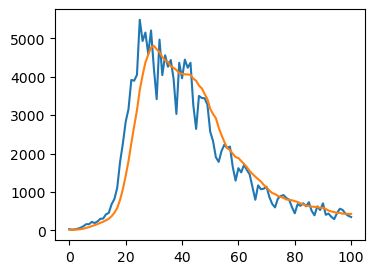

In [24]:
time = np.arange(0,len(data))
data = real_data['new_cases']
data_7d_avg = real_data['new_cases_7d_average']

fig, ax = plt.subplots(figsize=(4,3))

ax.plot(time, data)
ax.plot(time, data_7d_avg)

(958, 3)

In [45]:
sliding_windows = []
for i in range(real_data_raw.shape[0]-7):
    sliding_windows.append(real_data_raw['new_cases'][i:i+7])
sliding_windows = np.array(sliding_windows)

In [48]:
sliding_windows

array([[1.8000e+01, 1.7000e+01, 2.0000e+01, ..., 2.2000e+01, 1.2000e+01,
        1.1000e+01],
       [1.7000e+01, 2.0000e+01, 2.3000e+01, ..., 1.2000e+01, 1.1000e+01,
        7.0000e+00],
       [2.0000e+01, 2.3000e+01, 2.2000e+01, ..., 1.1000e+01, 7.0000e+00,
        8.0000e+00],
       ...,
       [1.7007e+04, 1.2075e+04, 6.4323e+04, ..., 5.3617e+04, 4.5335e+04,
        4.1938e+04],
       [1.2075e+04, 6.4323e+04, 6.4588e+04, ..., 4.5335e+04, 4.1938e+04,
        1.4325e+04],
       [6.4323e+04, 6.4588e+04, 5.3617e+04, ..., 4.1938e+04, 1.4325e+04,
        1.1248e+04]])

In [55]:
sliding_windows[50]

array([ 33.,  19.,  29.,  44.,  70., 109., 163.])

In [56]:
sliding_windows[50:150].mean(axis=1)

array([  66.71428571,   85.        ,  114.14285714,  137.28571429,
        164.57142857,  197.57142857,  226.14285714,  262.57142857,
        304.71428571,  370.14285714,  459.71428571,  584.85714286,
        796.14285714, 1075.28571429, 1419.71428571, 1805.85714286,
       2268.57142857, 2708.71428571, 3128.85714286, 3658.42857143,
       4040.        , 4372.14285714, 4577.71428571, 4761.71428571,
       4809.42857143, 4719.        , 4645.28571429, 4518.28571429,
       4433.71428571, 4386.14285714, 4276.28571429, 4235.42857143,
       4180.42857143, 4094.14285714, 4082.42857143, 4066.42857143,
       4062.57142857, 4052.14285714, 3954.        , 3898.28571429,
       3774.85714286, 3701.57142857, 3557.71428571, 3420.42857143,
       3164.        , 3030.85714286, 2925.71428571, 2680.28571429,
       2482.57142857, 2309.71428571, 2148.42857143, 2093.        ,
       1996.71428571, 1909.42857143, 1886.        , 1806.85714286,
       1731.71428571, 1650.        , 1546.42857143, 1471.     